In [1]:
#!python -m spacy download fr
#!pip install ecco
#!python -m spacy download fr_core_news_sm
#!python -m spacy download en_core_web_sm

In [2]:
from io import open
import unicodedata
import string
import re
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator
from collections import Counter 

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

In [3]:
#%%capture
#!wget https://download.pytorch.org/tutorial/data.zip && unzip data.zip && rm data.zip

In [4]:
MAX_SENTENCE_LENGTH = 20
FILTER_TO_BASIC_PREFIXES = False
SAVE_DIR = os.path.join(".", "models")

ENCODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_SIZE = 256
DECODER_EMBEDDING_DIM = 256
DECODER_HIDDEN_SIZE = 256

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
device

device(type='cuda')

In [6]:
if torch.cuda.is_available():
    !nvidia-smi

Thu Nov  9 13:19:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0  On |                  N/A |
|  0%   40C    P5    20W / 280W |    422MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
with open('./data/eng-fra.txt', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')

print(f"{len(lines):,} English-French phrase pairs.\n")
print("~~~~~ Examples: ~~~~~")
for example in random.choices(lines, k=5):
    pair = example.split('\t')
    print(f"English:  {pair[0]}")
    print(f"French:   {pair[1]}")
    print()

135,842 English-French phrase pairs.

~~~~~ Examples: ~~~~~
English:  He rolled his eyes.
French:   Il roula des yeux.

English:  We must water the flower.
French:   Nous devons arroser la fleur.

English:  He asked for money.
French:   Il a quémandé de l'argent.

English:  Let me try again.
French:   Laissez-moi réessayer !

English:  He seemed to like that.
French:   Il eut l'air de l'apprécier.



In [8]:
def unicodeToAscii(s):
    return ''.join(
      c for c in unicodedata.normalize('NFD', s) 
      if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z.!?]+", " ", s)
    return s

In [9]:
def filterPair(p, max_length, prefixes):
    good_length = (len(p[0].split(' ')) < max_length) and (len(p[1].split(' ')) < max_length)
    if len(prefixes) == 0:
        return good_length
    else:
        return good_length and p[0].startswith(prefixes)

def filterPairs(pairs, max_length, prefixes=()):
    return [pair for pair in pairs if filterPair(pair, max_length, prefixes)]

In [10]:
def prepareData(lines, filter=False, reverse=False, max_length=10, prefixes=()):
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    print(f"Given {len(pairs):,} sentence pairs.")

    if filter:
        pairs = filterPairs(pairs, max_length=max_length, prefixes=prefixes)
        print(f"After filtering, {len(pairs):,} remain.")

    return pairs

In [11]:
basic_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    'are you', 'am i ', 
    'were you', 'was i ', 
    'where are', 'where is',
    'what is', 'what are'
)

In [12]:
pairs = prepareData(lines, 
                    filter=True, 
                    max_length=MAX_SENTENCE_LENGTH, 
                    prefixes=basic_prefixes if FILTER_TO_BASIC_PREFIXES else ())

Given 135,842 sentence pairs.
After filtering, 135,284 remain.


In [13]:
pairs

[['go.', 'va !'],
 ['run!', 'cours !'],
 ['run!', 'courez !'],
 ['wow!', 'ca alors !'],
 ['fire!', 'au feu !'],
 ['help!', 'a l aide !'],
 ['jump.', 'saute.'],
 ['stop!', 'ca suffit !'],
 ['stop!', 'stop !'],
 ['stop!', 'arrete toi !'],
 ['wait!', 'attends !'],
 ['wait!', 'attendez !'],
 ['i see.', 'je comprends.'],
 ['i try.', 'j essaye.'],
 ['i won!', 'j ai gagne !'],
 ['i won!', 'je l ai emporte !'],
 ['oh no!', 'oh non !'],
 ['attack!', 'attaque !'],
 ['attack!', 'attaquez !'],
 ['cheers!', 'sante !'],
 ['cheers!', 'a votre sante !'],
 ['cheers!', 'merci !'],
 ['get up.', 'leve toi.'],
 ['got it!', 'j ai pige !'],
 ['got it!', 'compris !'],
 ['got it?', 'pige ?'],
 ['got it?', 'compris ?'],
 ['got it?', 't as capte ?'],
 ['hop in.', 'monte.'],
 ['hop in.', 'montez.'],
 ['hug me.', 'serre moi dans tes bras !'],
 ['hug me.', 'serrez moi dans vos bras !'],
 ['i fell.', 'je suis tombee.'],
 ['i fell.', 'je suis tombe.'],
 ['i know.', 'je sais.'],
 ['i left.', 'je suis parti.'],
 ['i le

In [14]:
#fr_tokenizer = get_tokenizer('spacy', language='fr')
#en_tokenizer = get_tokenizer('spacy', language='en')
fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [15]:
SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

In [16]:
en_list = []
fr_list = []
en_counter = Counter()
fr_counter = Counter()
en_lengths = []
fr_lengths = []
for en, fr in pairs:
    en_toks = en_tokenizer(en)
    fr_toks = fr_tokenizer(fr)
    #print(en_toks,fr_toks)
    en_list += [en_toks]
    fr_list += [fr_toks]
    en_counter.update(en_toks)
    fr_counter.update(fr_toks)
    en_lengths.append(len(en_toks))
    fr_lengths.append(len(fr_toks))

In [17]:
en_vocab = build_vocab_from_iterator(en_list, specials=SPECIALS)
fr_vocab = build_vocab_from_iterator(fr_list, specials=SPECIALS)

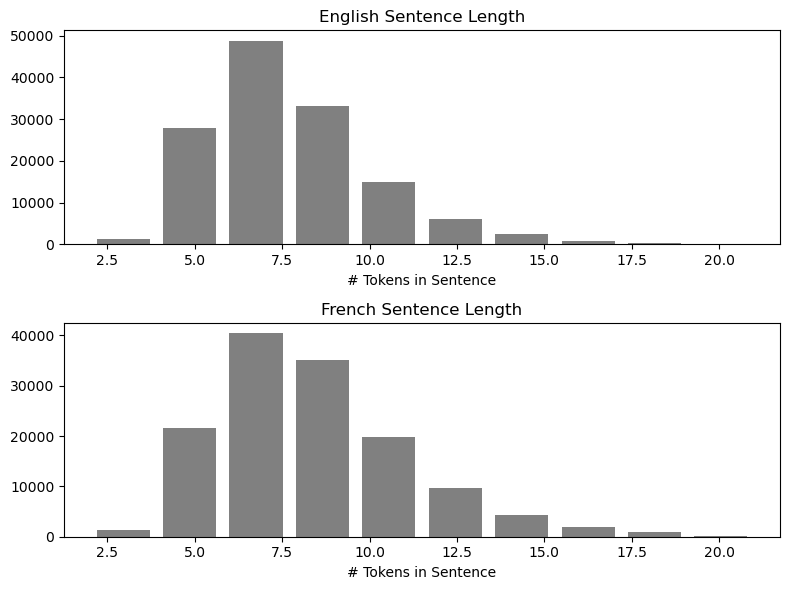

In [18]:
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(211)
ax0.hist(en_lengths, rwidth=0.8, color='gray')
ax0.set_title("English Sentence Length")
ax0.set_xlabel("# Tokens in Sentence")

ax1 = fig.add_subplot(212)
ax1.hist(fr_lengths, rwidth=0.8, color='gray')
ax1.set_title("French Sentence Length")
ax1.set_xlabel("# Tokens in Sentence")

plt.tight_layout()
plt.show()

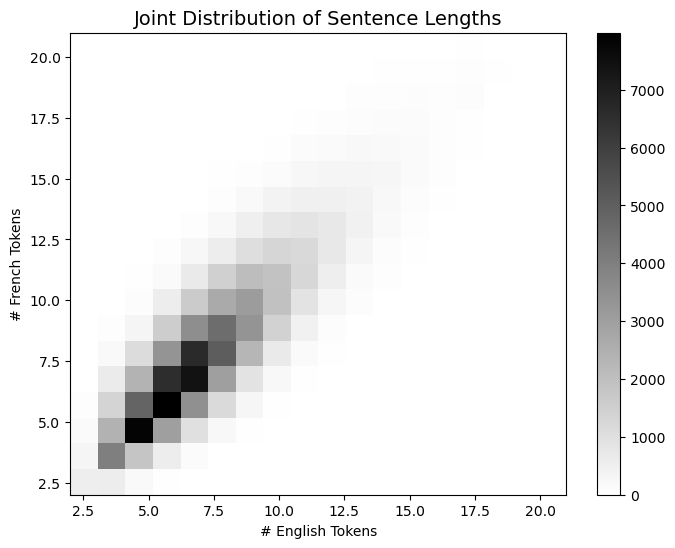

In [19]:
plt.figure(figsize=(8,6))
plt.hist2d(en_lengths, fr_lengths, bins=MAX_SENTENCE_LENGTH-2, cmap='binary')
plt.title("Joint Distribution of Sentence Lengths", fontsize=14)
plt.xlabel("# English Tokens")
plt.ylabel("# French Tokens")
plt.colorbar()
plt.show()

In [20]:
def plot_top_words(counter, k=20, ax=None):
    top_k = counter.most_common(k)
    words, freqs = zip(*reversed(top_k))
    
    if ax is None:
        plt.barh(words, freqs, color='gray')
    else:
        ax.barh(words, freqs, color='gray')

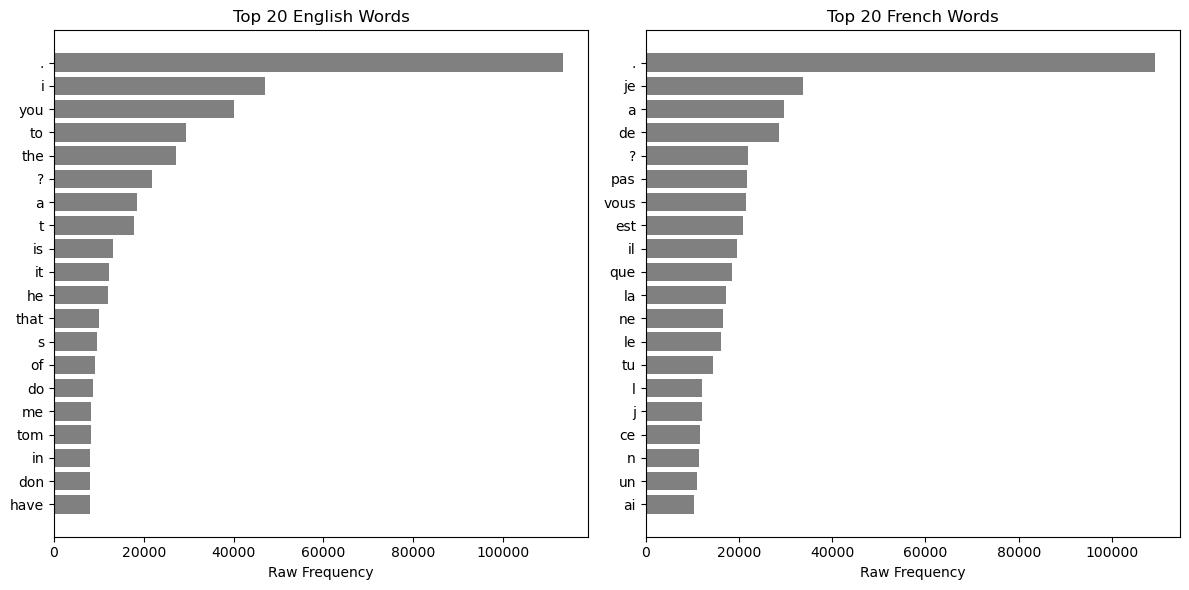

In [21]:
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121)
plot_top_words(en_counter, ax=ax0)
ax0.set_title("Top 20 English Words")
ax0.set_xlabel("Raw Frequency")

ax1 = fig.add_subplot(122)
plot_top_words(fr_counter, ax=ax1)
ax1.set_title("Top 20 French Words")
ax1.set_xlabel("Raw Frequency")

plt.tight_layout()
plt.show()

In [22]:
VALID_PCT = 0.05
TEST_PCT  = 0.05
#TRAIN_PCT = 0.15
train_data = []
valid_data = []
test_data = []

random.seed(6547)
for (en, fr) in pairs:
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(en)])
    fr_tensor_ = torch.tensor([fr_vocab[token] for token in fr_tokenizer(fr)])
    random_draw = random.random()
    if random_draw <= VALID_PCT:
        valid_data.append((en_tensor_, fr_tensor_))
    elif random_draw <= VALID_PCT + TEST_PCT:
        test_data.append((en_tensor_, fr_tensor_))
    else:
        #if random_draw <= TRAIN_PCT and random_draw > (VALID_PCT + TEST_PCT):
        train_data.append((en_tensor_, fr_tensor_))


print(f"""
  Training pairs: {len(train_data):,}
Validation pairs: {len(valid_data):,}
      Test pairs: {len(test_data):,}""")
     


  Training pairs: 121,636
Validation pairs: 6,855
      Test pairs: 6,793


In [23]:
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

for en_id, fr_id in zip(en_vocab.lookup_indices(SPECIALS), fr_vocab.lookup_indices(SPECIALS)):
  assert en_id == fr_id

In [24]:
def generate_batch(data_batch):
    '''
    Prepare English and French examples for batch-friendly modeling by appending
    BOS/EOS tokens to each, stacking the tensors, and filling trailing spaces of
    shorter sentences with the  token. To be used as the collate_fn in the
    English-to-French DataLoader.

    Input: 
    - data_batch, an iterable of (English, French) tuples from the datasets 
      created above

    Outputs
    - en_batch: a (max length X batch size) tensor of English token IDs
    - fr_batch: a (max length X batch size) tensor of French token IDs 
    '''
    en_batch, fr_batch = [], []
    for (en_item, fr_item) in data_batch:
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
        fr_batch.append(torch.cat([torch.tensor([BOS_IDX]), fr_item, torch.tensor([EOS_IDX])], dim=0))

    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=False)
    fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX, batch_first=False)

    return en_batch, fr_batch

In [25]:
BATCH_SIZE = 16

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

In [26]:
for i, (en_id, fr_id) in enumerate(train_iter):
    print('English:', ' '.join([en_vocab.lookup_token(idx) for idx in en_id[:, 0]]))
    print('French:', ' '.join([fr_vocab.lookup_token(idx) for idx in fr_id[:, 0]]))
    if i == 4: 
        break
    else:
        print()

English: <bos> i m sure about his name . <eos> <pad> <pad> <pad>
French: <bos> je suis sur de son nom . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <bos> tom should come right away . <eos> <pad> <pad> <pad> <pad> <pad> <pad>
French: <bos> tom devrais venir tout de suite . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <bos> she is powerful . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
French: <bos> elle est puissante . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <bos> you must stop him . <eos> <pad> <pad> <pad> <pad> <pad>
French: <bos> tu dois l arreter . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <bos> his voice is pleasant to listen to . <eos> <pad> <pad> <pad> <pad> <pad>
French: <bos> sa voix est agreable a ecouter . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [27]:
class BahdanauEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, 
                 decoder_hidden_dim, dropout_p):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.linear = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        '''
        Encode a source sentence. 

        Input:
          - x: a (sequence length, batch size) tensor of token IDs in source language

        Output:
          - outputs: encoder outputs at each time step, given as a tensor of size
            (sequence length, batch size, encoder hidden dim * 2)
          - hidden: final hidden state from RNN, with directions concatenated and
            fed through linear layer; tensor of size (batch size, decoder hidden dim)
        '''

        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.gru(embedded)

        hidden = torch.tanh(self.linear(
            torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        ))

        return outputs, hidden

In [28]:
class BahdanauAttentionQKV(nn.Module):
    def __init__(self, hidden_size, query_size=None, key_size=None, dropout_p=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.query_size = hidden_size if query_size is None else query_size
        
        # assume bidirectional encoder, but can specify otherwise
        self.key_size = 2*hidden_size if key_size is None else key_size
        
        self.query_layer = nn.Linear(self.query_size, hidden_size)
        self.key_layer = nn.Linear(self.key_size, hidden_size)
        self.energy_layer = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, hidden, encoder_outputs, src_mask=None):
        '''
        Calculate attention weights using query and key features, with
        an optional mask for input sequences.
        
        Inputs:
          - hidden: most recent RNN hidden state; (B, Dec)
          - encoder_outputs: RNN outputs at individual time steps with 
            directions concatenated; (L, B, 2*Enc)
          - src_mask: boolean tensor of same size as source tokens (Src, B) 
            where False denotes tokens to be ignored
            
        Outputs:
          - attention weights: (B, src) tensor of softmax attention 
            weights to be applied to downstream values
        '''
        
        # (B, H)
        query_out = self.query_layer(hidden) 
        
        # (Src, B, 2*H) --> (Src, B, H)
        key_out = self.key_layer(encoder_outputs) 
        
        # (B, H) + (Src, B, H) = (Src, B, H)
        energy_input = torch.tanh(query_out + key_out) 
        
        # (Src, B, H) --> (Src, B, 1) --> (Src, B)
        energies = self.energy_layer(energy_input).squeeze(2) 
        
        # if a mask is provided, remove masked tokens from softmax calc
        if src_mask is not None:
            energies.data.masked_fill_(src_mask == 0, float("-inf"))
        
        # softmax over the length dimension
        weights = F.softmax(energies, dim=0)
        
        # return as (B, Src) as expected by later multiplication
        return weights.transpose(0, 1)

In [29]:
class BahdanauDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim, 
                 decoder_hidden_dim, attention, dropout_p):
        super().__init__()

        self.embedding_dim = embedding_dim 
        self.output_dim = output_dim 
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p 

        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = attention # allowing for custom attention
        self.gru = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, 
                          decoder_hidden_dim)
        self.out = nn.Linear((encoder_hidden_dim * 2) + embedding_dim + decoder_hidden_dim,
                             output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input, hidden, encoder_outputs, src_mask=None):
        '''
        Decode an encoder's output. 

        B: batch size
        S: source sentence length
        T: target sentence length
        O: output size (target vocab size)
        Enc: encoder hidden dim
        Dec: decoder hidden dim
        Emb: embedding dim

        Inputs:
          - input: a vector of length B giving the most recent decoded token
          - hidden: a (B, Dec) most recent RNN hidden state
          - encoder_outputs: (S, B, 2*Enc) sequence of outputs from encoder RNN

        Outputs:
          - output: logits for next token in the sequence (B, O)
          - hidden: a new (B, Dec) RNN hidden state
          - attentions: (B, S) attention weights for the current token over the source sentence
        '''

        # (B) --> (1, B)
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        attentions = self.attention(hidden, encoder_outputs, src_mask)

        # (B, S) --> (B, 1, S)
        a = attentions.unsqueeze(1)

        # (S, B, 2*Enc) --> (B, S, 2*Enc)
        encoder_outputs = encoder_outputs.transpose(0, 1)

        # weighted encoder representation
        # (B, 1, S) @ (B, S, 2*Enc) = (B, 1, 2*Enc)
        weighted = torch.bmm(a, encoder_outputs)

        # (B, 1, 2*Enc) --> (1, B, 2*Enc)
        weighted = weighted.transpose(0, 1)

        # concat (1, B, Emb) and (1, B, 2*Enc)
        # results in (1, B, Emb + 2*Enc)
        rnn_input = torch.cat((embedded, weighted), dim=2)

        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        # get rid of empty leading dimensions
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        # concatenate the pieces above
        # (B, Dec), (B, 2*Enc), and (B, Emb)
        # result is (B, Dec + 2*Enc + Emb)
        linear_input = torch.cat((output, weighted, embedded), dim=1)

        # (B, Dec + 2*Enc + Emb) --> (B, O)
        output = self.out(linear_input)

        return output, hidden.squeeze(0), attentions

In [30]:
class BahdanauSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        self.tgt_vocab_size = decoder.output_dim

    def forward(self, src, tgt, src_mask=None, teacher_forcing_ratio=0.5, return_attentions=False):

        tgt_length, batch_size = tgt.shape

        # store decoder outputs
        outputs = torch.zeros(tgt_length, batch_size, self.tgt_vocab_size).to(self.device)
        # attentions = torch.zeros(tgt_length, batch_size, )

        encoder_outputs, hidden = self.encoder(src)
        hidden = hidden.squeeze(1) # B, 1, Enc --> B, Enc (if necessary)

        # start with  as the decoder input
        decoder_input = tgt[0, :]
        attentions = []

        for t in range(1, tgt_length):
            decoder_output, hidden, attention = self.decoder(decoder_input, hidden, encoder_outputs, src_mask)
            outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top_token = decoder_output.max(1)[1]
            decoder_input = (tgt[t] if teacher_force else top_token)
            attentions.append(attention.unsqueeze(-1))

        if return_attentions:
            return outputs, torch.cat(attentions, dim=-1)
        else:
            return outputs

In [31]:
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op
        
    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()
    
    def step(self):
        for op in self.optimizers:
            op.step()

In [32]:
def train(model, iterator, optimizer, loss_fn, device, clip=None):
    model.train()
    if model.device != device:
        model = model.to(device)
        
    epoch_loss = 0
    with tqdm(total=len(iterator), leave=False) as t:
        for i, (src, tgt) in enumerate(iterator):
            src_mask = (src != PAD_IDX).to(device)
            src = src.to(device)
            tgt = tgt.to(device)
            
            optimizer.zero_grad()
            
            output = model(src, tgt, src_mask)
            
            loss = loss_fn(output[1:].view(-1, output.shape[2]),
                           tgt[1:].view(-1))
            
            loss.backward()
            
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            epoch_loss += loss.item()
            
            avg_loss = epoch_loss / (i+1)
            t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                          ppl='{:05.3f}'.format(np.exp(avg_loss)))
            t.update()
            
    return epoch_loss / len(iterator)

In [33]:
def evaluate(model, iterator, loss_fn, device):
    model.eval()
    if model.device != device:
        model = model.to(device)
        
    epoch_loss = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), leave=False) as t:
            for i, (src, tgt) in enumerate(iterator):
                src_mask = (src != PAD_IDX).to(device)
                src = src.to(device)
                tgt = tgt.to(device)
                
                output = model(src, tgt, src_mask, teacher_forcing_ratio=0)
                loss = loss_fn(output[1:].view(-1, output.shape[2]),
                               tgt[1:].view(-1))
                
                epoch_loss += loss.item()
                
                avg_loss = epoch_loss / (i+1)
                t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                              ppl='{:05.3f}'.format(np.exp(avg_loss)))
                t.update()
    
    return epoch_loss / len(iterator)

In [34]:
enc = BahdanauEncoder(input_dim=len(en_vocab),
                      embedding_dim=ENCODER_EMBEDDING_DIM, 
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE, 
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE, 
                      dropout_p=0.15)

attn = BahdanauAttentionQKV(DECODER_HIDDEN_SIZE)

dec = BahdanauDecoder(output_dim=len(fr_vocab), 
                      embedding_dim=DECODER_EMBEDDING_DIM,
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE, 
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE,
                      attention=attn,
                      dropout_p=0.15)

In [35]:
print(len(en_vocab),len(fr_vocab))

12938 21189


In [36]:
seq2seq = BahdanauSeq2Seq(enc, dec, device)

In [37]:
def count_params(model, return_int=False):
    params = sum([torch.prod(torch.tensor(x.shape)).item() for x in model.parameters() if x.requires_grad])
    if return_int:
        return params
    else:
        print("There are {:,} trainable parameters in this model.".format(params))

In [38]:
count_params(seq2seq)

There are 32,361,414 trainable parameters in this model.


In [39]:
enc_optim = torch.optim.AdamW(seq2seq.encoder.parameters(), lr=1e-4)
dec_optim = torch.optim.AdamW(seq2seq.decoder.parameters(), lr=1e-4)
optims = MultipleOptimizer(enc_optim, dec_optim)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [40]:
N_EPOCHS = 20
CLIP = 10 # clipping value, or None to prevent gradient clipping
EARLY_STOPPING_EPOCHS = 2

if not os.path.exists(SAVE_DIR):
    print(f"Creating directory {SAVE_DIR}")
    os.mkdir(SAVE_DIR)
    
model_path = os.path.join(SAVE_DIR, 'bahdanau_en_fr.pt')
bahdanau_metrics = {}
best_valid_loss = float("inf")
early_stopping_count = 0
for epoch in tqdm(range(N_EPOCHS), leave=False, desc="Epoch"):
    train_loss = train(seq2seq, train_iter, optims, loss_fn, device, clip=CLIP)
    valid_loss = evaluate(seq2seq, valid_iter, loss_fn, device)
    
    if valid_loss < best_valid_loss:
        tqdm.write(f"Checkpointing at epoch {epoch + 1}")
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), model_path)
        early_stopping_count = 0
    else:
        early_stopping_count += 1
    
    bahdanau_metrics[epoch+1] = dict(
        train_loss = train_loss,
        train_ppl = np.exp(train_loss),
        valid_loss = valid_loss,
        valid_ppl = np.exp(valid_loss)
    )
    
    if early_stopping_count == EARLY_STOPPING_EPOCHS:
        tqdm.write(f"Early stopping triggered in epoch {epoch + 1}")
        break

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 1


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 2


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 3


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 4


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 5


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 6


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 7


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 8


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 9


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 10


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 11


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 12


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 13


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 14


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 15


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 16


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Early stopping triggered in epoch 18


In [41]:
seq2seq.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

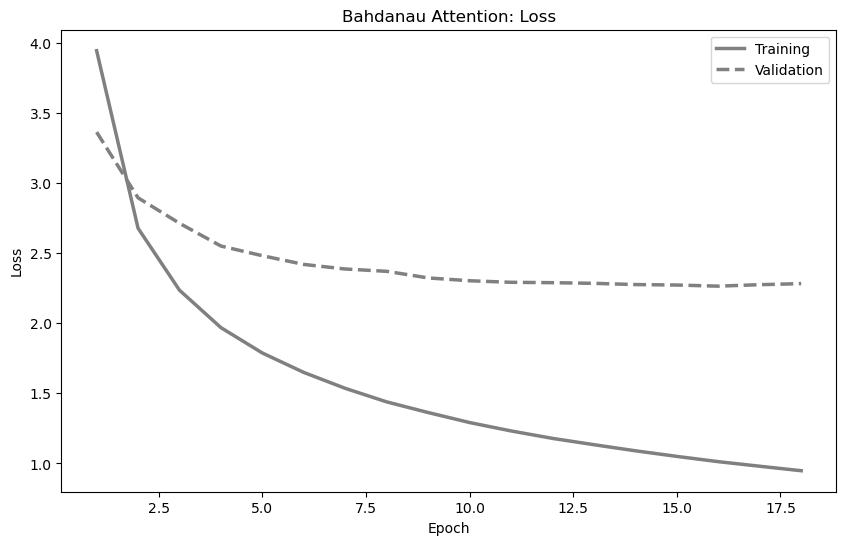

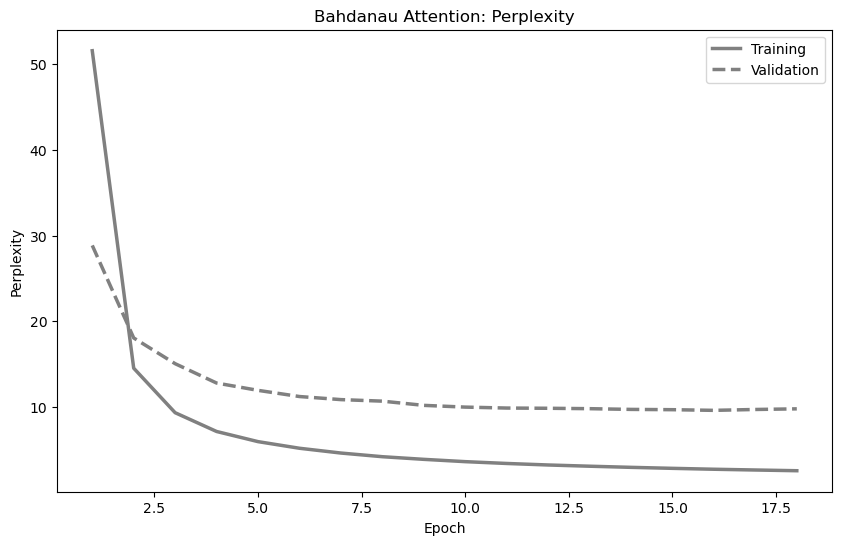

In [42]:
bahdanau_metrics_df = pd.DataFrame(bahdanau_metrics).T

plt.figure(figsize=(10,6))
plt.plot(bahdanau_metrics_df['train_loss'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(bahdanau_metrics_df['valid_loss'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Bahdanau Attention: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(bahdanau_metrics_df['train_ppl'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(bahdanau_metrics_df['valid_ppl'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Bahdanau Attention: Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.show()

In [43]:
best_valid_loss

2.2639507540178188

In [44]:
def predict_text(model, text, device=device, src_vocab=en_vocab, src_tokenizer=en_tokenizer, tgt_vocab=fr_vocab):
    model.eval()
    with torch.no_grad():
        input_ids = [src_vocab[token] for token in src_tokenizer(text)]
        input_ids = [BOS_IDX] + input_ids + [EOS_IDX]
        input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) # add fake batch dim
        max_len = 2*len(input_ids)
        encoder_outputs, hidden = model.encoder(input_tensor)
        
        output = torch.tensor([BOS_IDX]).to(device)
        
        decoder_outputs = torch.zeros(max_len, 1, len(tgt_vocab)).to(device)
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_len, len(input_ids))
        for t in range(0, max_len):
            output, hidden, attn = model.decoder(output, hidden, encoder_outputs)
            decoder_attentions[t] = attn.data
            decoder_outputs[t] = output
            output = output.argmax(1)
            
            if output.item() == EOS_IDX:
                decoded_words.append('')
                break
            else:
                decoded_words.append(tgt_vocab.lookup_token(output.item()))
        
        output_sentence = ' '.join(decoded_words)
        return output_sentence, decoder_attentions[:(t+1)]

def show_attention(input_sentence, output_sentence, attentions, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='gray')
    fig.colorbar(cax)
    
    src = ['', ''] + input_sentence.split(' ') + ['']
    tgt = [''] + output_sentence.split(' ')
    ax.set_xticklabels(src, rotation=90)
    ax.set_yticklabels(tgt)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def predict_and_show_attention(sentence, model, device):
    result, attentions = predict_text(model, sentence, device)
    
    print("Input  >>>", sentence)
    print("Output >>>", result)
    
    show_attention(sentence, result, attentions)

Input  >>> i am going to the store
Output >>> je vais a le magasin . 


/tmp/ipykernel_4376/795855007.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_4376/795855007.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


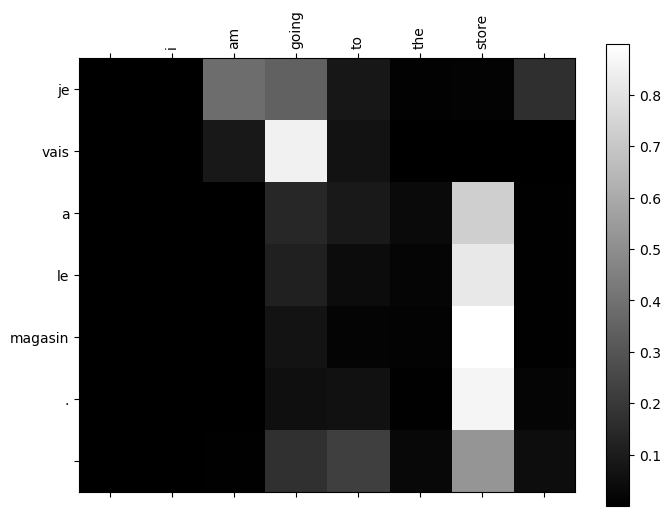

In [45]:
predict_and_show_attention("i am going to the store", seq2seq, device)

Input  >>> how long will you be here ?
Output >>> combien de temps serez vous ici ? 


/tmp/ipykernel_4376/795855007.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_4376/795855007.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


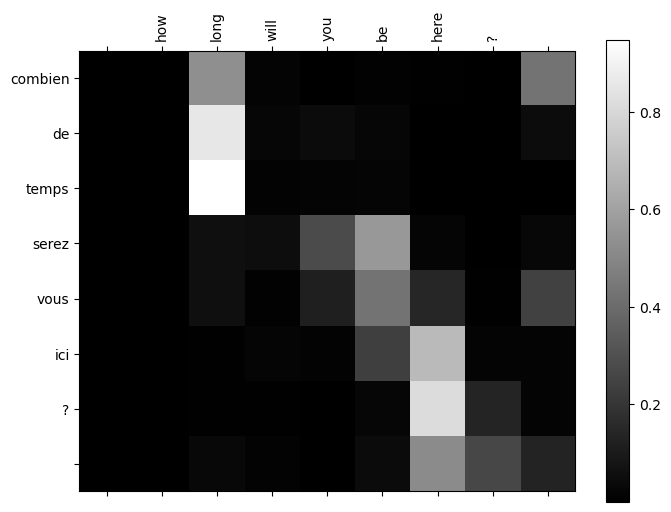

In [46]:
predict_and_show_attention("how long will you be here ?", seq2seq, device)

Input  >>> can we please go to the library ?
Output >>> pouvons nous aller a la bibliotheque ? 


/tmp/ipykernel_4376/795855007.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_4376/795855007.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


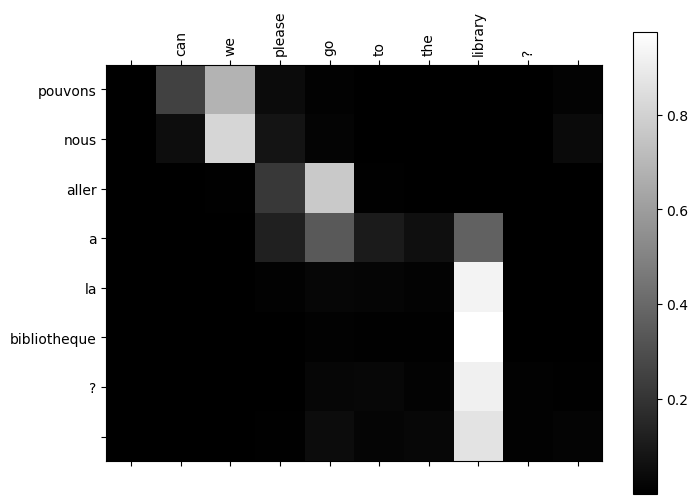

In [47]:
predict_and_show_attention("can we please go to the library ?", seq2seq, device)

Input  >>> her family moved away last year .
Output >>> sa famille s est passee l annee derniere . 


/tmp/ipykernel_4376/795855007.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_4376/795855007.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


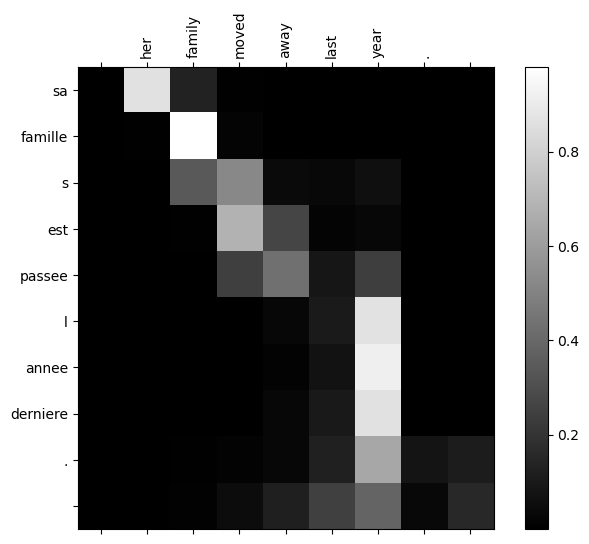

In [48]:
if not FILTER_TO_BASIC_PREFIXES:
  predict_and_show_attention("her family moved away last year .", seq2seq, device)

Input  >>> two thousand people fit into this hall .
Output >>> deux mille personnes ont dans dans cette hall . 


/tmp/ipykernel_4376/795855007.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_4376/795855007.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


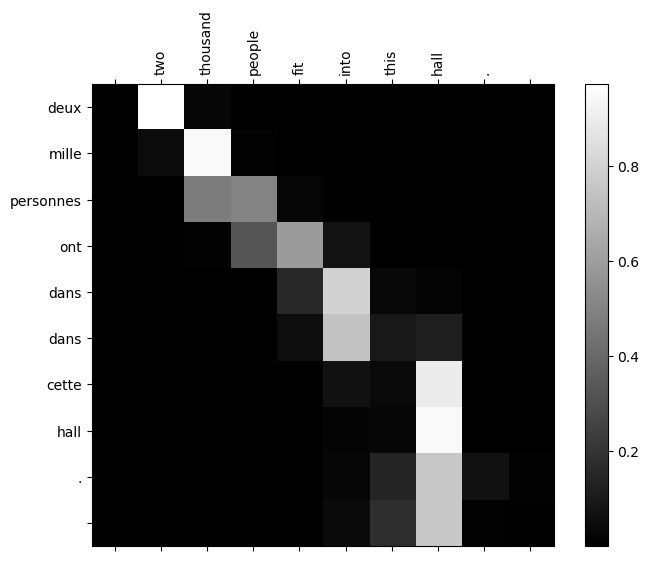

In [49]:
if not FILTER_TO_BASIC_PREFIXES:
  predict_and_show_attention("two thousand people fit into this hall .", seq2seq, device)

Input  >>> the poor young man finally became a great artist .
Output >>> le pauvre jeune homme devint un grand artiste . 


/tmp/ipykernel_4376/795855007.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_4376/795855007.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


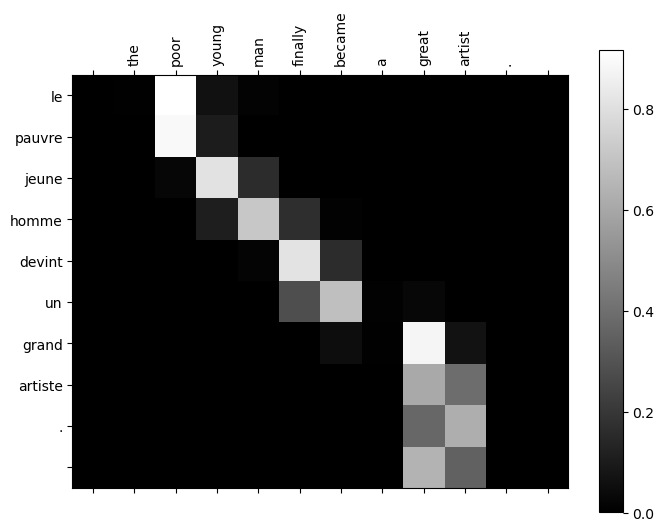

In [50]:
if not FILTER_TO_BASIC_PREFIXES:
  predict_and_show_attention("the poor young man finally became a great artist .", seq2seq, device)

In [51]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_p=0.1, max_len=100):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, num_attention_heads, 
                 num_encoder_layers, num_decoder_layers, dim_feedforward, 
                 max_seq_length, pos_dropout, transformer_dropout):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Embedding(input_dim, d_model)
        self.embed_tgt = nn.Embedding(output_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)
        
        self.transformer = nn.Transformer(d_model, num_attention_heads, num_encoder_layers, 
                                          num_decoder_layers, dim_feedforward, transformer_dropout)
        self.output = nn.Linear(d_model, output_dim)
        
    def forward(self,
                src=None, 
                tgt=None,
                src_mask=None,
                tgt_mask=None, 
                src_key_padding_mask=None, 
                tgt_key_padding_mask=None,
                memory_key_padding_mask=None,
                src_embeds=None, 
                tgt_embeds=None):
        
        if (src_embeds is None) and (src is not None):
            if (tgt_embeds is None) and (tgt is not None):
                src_embeds, tgt_embeds = self._embed_tokens(src, tgt)
        elif (src_embeds is not None) and (src is not None):
            raise ValueError("Must specify exactly one of src and src_embeds")
        elif (src_embeds is None) and (src is None):
            raise ValueError("Must specify exactly one of src and src_embeds")
        elif (tgt_embeds is not None) and (tgt is not None):
            raise ValueError("Must specify exactly one of tgt and tgt_embeds")
        elif (tgt_embeds is None) and (tgt is None):
            raise ValueError("Must specify exactly one of tgt and tgt_embeds")
        
        output = self.transformer(src_embeds, 
                                  tgt_embeds, 
                                  tgt_mask=tgt_mask, 
                                  src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask)
        
        return self.output(output)
    
    def _embed_tokens(self, src, tgt):
        src_embeds = self.embed_src(src) * np.sqrt(self.d_model)
        tgt_embeds = self.embed_tgt(tgt) * np.sqrt(self.d_model)
        
        src_embeds = self.pos_enc(src_embeds)
        tgt_embeds = self.pos_enc(tgt_embeds)
        return src_embeds, tgt_embeds

In [52]:
def train_transformer(model, iterator, optimizer, loss_fn, device, clip=None):
    model.train()
        
    epoch_loss = 0
    with tqdm(total=len(iterator), leave=False) as t:
        for i, (src, tgt) in enumerate(iterator):
            src = src.to(device)
            tgt = tgt.to(device)
            
            # Create tgt_inp and tgt_out (which is tgt_inp but shifted by 1)
            tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :]

            tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_inp.size(0)).to(device)
            src_key_padding_mask = (src == PAD_IDX).transpose(0, 1)
            tgt_key_padding_mask = (tgt_inp == PAD_IDX).transpose(0, 1)
            memory_key_padding_mask = src_key_padding_mask.clone()
            
            optimizer.zero_grad()
            
            output = model(src=src, tgt=tgt_inp, 
                           tgt_mask=tgt_mask,
                           src_key_padding_mask = src_key_padding_mask,
                           tgt_key_padding_mask = tgt_key_padding_mask,
                           memory_key_padding_mask = memory_key_padding_mask)
            
            loss = loss_fn(output.view(-1, output.shape[2]),
                           tgt_out.view(-1))
            
            loss.backward()
            
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            epoch_loss += loss.item()
            
            avg_loss = epoch_loss / (i+1)
            t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                          ppl='{:05.3f}'.format(np.exp(avg_loss)))
            t.update()
            
    return epoch_loss / len(iterator)
    
def evaluate_transformer(model, iterator, loss_fn, device):
    model.eval()
        
    epoch_loss = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), leave=False) as t:
            for i, (src, tgt) in enumerate(iterator):
                src = src.to(device)
                tgt = tgt.to(device)
                
                # Create tgt_inp and tgt_out (which is tgt_inp but shifted by 1)
                tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :]
                
                tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_inp.size(0)).to(device)
                src_key_padding_mask = (src == PAD_IDX).transpose(0, 1)
                tgt_key_padding_mask = (tgt_inp == PAD_IDX).transpose(0, 1)
                memory_key_padding_mask = src_key_padding_mask.clone()

                output = model(src=src, tgt=tgt_inp, 
                               tgt_mask=tgt_mask,
                               src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask = tgt_key_padding_mask,
                               memory_key_padding_mask = memory_key_padding_mask)
                
                loss = loss_fn(output.view(-1, output.shape[2]),
                               tgt_out.view(-1))
                
                epoch_loss += loss.item()
                
                avg_loss = epoch_loss / (i+1)
                t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                              ppl='{:05.3f}'.format(np.exp(avg_loss)))
                t.update()
    
    return epoch_loss / len(iterator)

In [53]:
transformer = TransformerModel(input_dim=len(en_vocab), 
                             output_dim=len(fr_vocab), 
                             d_model=256, 
                             num_attention_heads=8,
                             num_encoder_layers=6, 
                             num_decoder_layers=6, 
                             dim_feedforward=2048,
                             max_seq_length=32,
                             pos_dropout=0.15,
                             transformer_dropout=0.3)

transformer = transformer.to(device)

/home/turunenj/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [54]:
count_params(transformer)

There are 31,546,053 trainable parameters in this model.


In [55]:
xf_optim = torch.optim.AdamW(transformer.parameters(), lr=1e-4)

In [56]:
%%time
N_EPOCHS = 50
CLIP = 15 # clipping value, or None to prevent gradient clipping
EARLY_STOPPING_EPOCHS = 5
    
model_path = os.path.join(SAVE_DIR, 'transformer_en_fr.pt')
transformer_metrics = {}
best_valid_loss = float("inf")
early_stopping_count = 0
for epoch in tqdm(range(N_EPOCHS), desc="Epoch"):
    train_loss = train_transformer(transformer, train_iter, xf_optim, loss_fn, device, clip=CLIP)
    valid_loss = evaluate_transformer(transformer, valid_iter, loss_fn, device)
    
    if valid_loss < best_valid_loss:
        tqdm.write(f"Checkpointing at epoch {epoch + 1}")
        best_valid_loss = valid_loss
        torch.save(transformer.state_dict(), model_path)
        early_stopping_count = 0
    elif epoch > EARLY_STOPPING_EPOCHS:
        early_stopping_count += 1
    
    transformer_metrics[epoch+1] = dict(
        train_loss = train_loss,
        train_ppl = np.exp(train_loss),
        valid_loss = valid_loss,
        valid_ppl = np.exp(valid_loss)
    )
    
    if early_stopping_count == EARLY_STOPPING_EPOCHS:
        tqdm.write(f"Early stopping triggered in epoch {epoch + 1}")
        break

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

/home/turunenj/anaconda3/lib/python3.11/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 1


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 2


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 3


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 4


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 5


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 6


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 7


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 8


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 9


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 10


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 11


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 12


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 13


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 14


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 15


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 16


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 17


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 18


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 19


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 20


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 21


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 22


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 23


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 24


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 25


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 26


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 28


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 29


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 31


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 32


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 33


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 34


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 38


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 39


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 40


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 42


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 44


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 46


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 48


  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7603 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

Checkpointing at epoch 50
CPU times: user 19h 48min 7s, sys: 1min 54s, total: 19h 50min 2s
Wall time: 4h 26min 49s


In [57]:
transformer.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

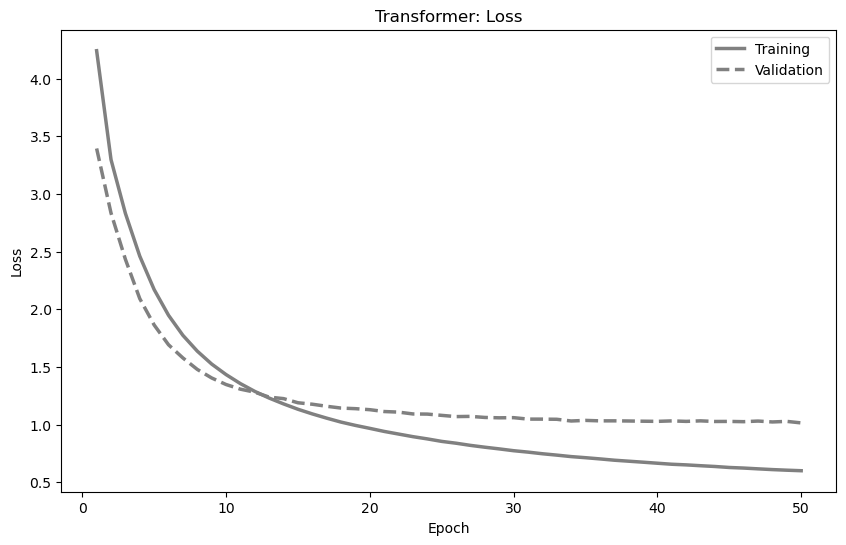

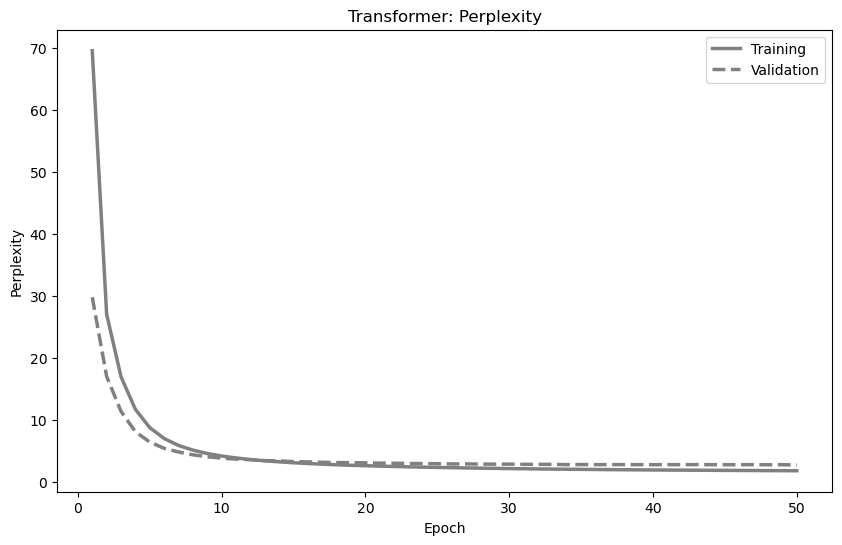

In [58]:
transformer_metrics_df = pd.DataFrame(transformer_metrics).T

plt.figure(figsize=(10,6))
plt.plot(transformer_metrics_df['train_loss'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(transformer_metrics_df['valid_loss'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Transformer: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(transformer_metrics_df['train_ppl'], label="Training", color='gray', linestyle='solid', lw=2.5)
plt.plot(transformer_metrics_df['valid_ppl'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
plt.legend()
plt.title("Transformer: Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.show()

In [59]:
best_valid_loss

1.0153475566343828

In [60]:
def predict_transformer(text, model,
                        src_vocab=en_vocab,
                        src_tokenizer=en_tokenizer,
                        tgt_vocab=fr_vocab,
                        device=device):

    input_ids = [src_vocab[token] for token in src_tokenizer(text)]
    input_ids = [BOS_IDX] + input_ids + [EOS_IDX]

    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) # add fake batch dim

        causal_out = torch.ones(MAX_SENTENCE_LENGTH, 1).long().to(device) * BOS_IDX
        for t in range(1, MAX_SENTENCE_LENGTH):
            decoder_output = transformer(input_tensor, causal_out[:t, :])[-1, :, :]
            next_token = decoder_output.data.topk(1)[1].squeeze()
            causal_out[t, :] = next_token
            if next_token.item() == EOS_IDX:
                break

        pred_words = [tgt_vocab.lookup_token(tok.item()) for tok in causal_out.squeeze(1)[1:(t)]]
        return " ".join(pred_words)

In [72]:
predict_transformer("want some chocolate", transformer)

'voulez !'

In [70]:
predict_transformer("i would go anywhere with you .", transformer)

'je .'

In [65]:
transformer = transformer.to('cuda')

In [66]:
test_loss = {}
test_loss['Bahdanau RNN'] = evaluate(seq2seq, test_iter, loss_fn, device)
test_loss['Transformer'] = evaluate_transformer(transformer, test_iter, loss_fn, device)

  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

/home/turunenj/anaconda3/lib/python3.11/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [67]:
test_ppl = {k:np.exp(v) for k, v in test_loss.items()}

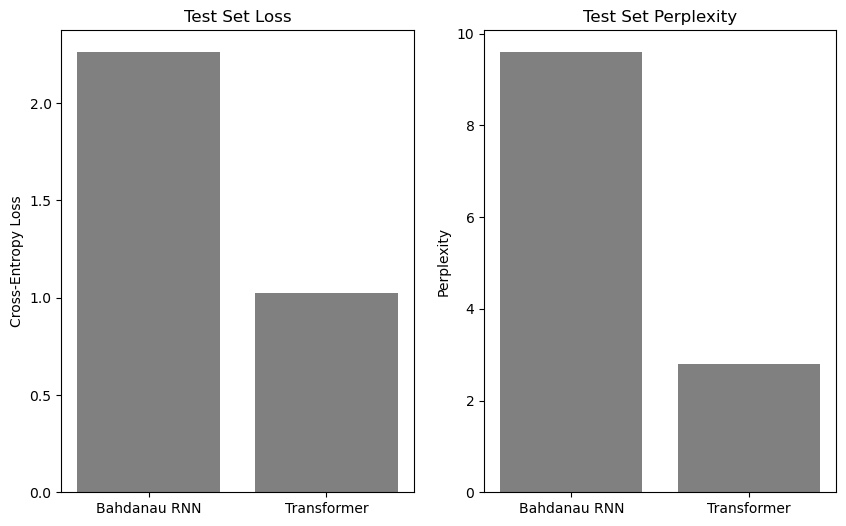

In [68]:
fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(121)
ax0.bar(test_loss.keys(), test_loss.values(), color='gray')
ax0.set_title("Test Set Loss")
ax0.set_ylabel("Cross-Entropy Loss")

ax1 = fig.add_subplot(122)
ax1.bar(test_ppl.keys(), test_ppl.values(), color='gray')
ax1.set_title("Test Set Perplexity")
ax1.set_ylabel("Perplexity")
plt.show()